In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
(img_train, _), (_, _) = keras.datasets.cifar100.load_data()


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [3]:
img_train.shape

(50000, 32, 32, 3)

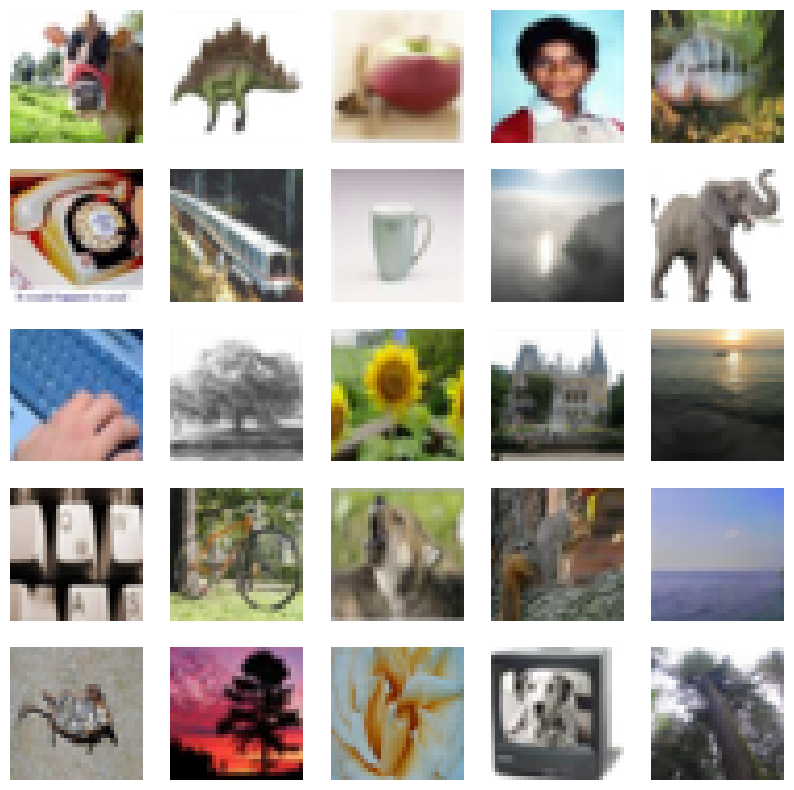

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(img_train[i])
  plt.axis("off")
plt.show()

In [5]:
img_train = img_train.reshape(img_train.shape[0], 32,32, 3 ).astype('float32')
img_train = (img_train - 127.5) / 127.5

In [6]:
img_train.shape

(50000, 32, 32, 3)

In [7]:
BUFFER_SIZE = 70000
BATCH_SIZE = 64

In [8]:
img_train

array([[[[ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         ...,
         [ 0.5294118 ,  0.60784316,  0.5137255 ],
         [ 0.6627451 ,  0.75686276,  0.6       ],
         [ 0.42745098,  0.52156866,  0.30980393]],

        [[ 1.        ,  1.        ,  1.        ],
         [ 0.99215686,  0.99215686,  0.99215686],
         [ 0.99215686,  0.99215686,  0.99215686],
         ...,
         [ 0.33333334,  0.38039216,  0.1764706 ],
         [ 0.2627451 ,  0.31764707,  0.01960784],
         [ 0.14509805,  0.20784314, -0.11372549]],

        [[ 1.        ,  1.        ,  1.        ],
         [ 0.99215686,  0.99215686,  0.99215686],
         [ 1.        ,  1.        ,  1.        ],
         ...,
         [ 0.48235294,  0.56078434,  0.3254902 ],
         [ 0.3019608 ,  0.39607844,  0.01960784],
         [-0.05098039,  0.04313726, -0.31764707]],

        ...,

        [[ 0.16078432,  0.4509804 , -0

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(img_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
LATENT_DIM = 100
WEIGHT_UNIT = keras.initializers.RandomNormal(mean= 0.0, stddev=0.02)

In [21]:
def build_generator():
    model = keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', activation='tanh')  # Ensure final size is (32,32,3)
    ])
    return model

genrator = build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
def build_discriminator():
    model = keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),  # Added Dropout
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),  # Added Dropout
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model
discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
cross_entropy = keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)  # Label smoothing
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [27]:

optimizer_gen = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_disc = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)  # Lower learning rate

In [28]:
# GAN Class
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, g_loss, d_loss):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        noise = tf.random.normal([batch_size, LATENT_DIM])
        with tf.GradientTape() as d_tape:
            generated_images = self.generator(noise, training=True)
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            d_loss = self.d_loss(real_output, fake_output)

        d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        noise = tf.random.normal([batch_size, LATENT_DIM])
        with tf.GradientTape() as g_tape:
            generated_images = self.generator(noise, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            g_loss = self.g_loss(fake_output)

        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

In [29]:
#Callback to visualize generated images
class ImageCallback(keras.callbacks.Callback):
    def __init__(self, num_images=16, latent_dim=100):
        self.num_images = num_images
        self.latent_dim = latent_dim
        self.seed = tf.random.normal([num_images, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            generated_images = self.model.generator(self.seed, training=False)
            generated_images = (generated_images * 127.5) + 127.5

            plt.figure(figsize=(10,10))
            for i in range(self.num_images):
                plt.subplot(4, 4, i+1)
                plt.imshow(generated_images[i].numpy().astype("uint8"))
                plt.axis("off")
            plt.show()

In [30]:
EPOCH = 100

In [31]:

gan = GAN(generator=genrator, discriminator=discriminator)  # Changed 'generator' to 'genrator'
gan.compile(
    g_optimizer=optimizer_gen,
    d_optimizer=optimizer_disc,
    g_loss=generator_loss,
    d_loss=discriminator_loss
)

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - d_loss: 2.1298 - g_loss: 4.1220

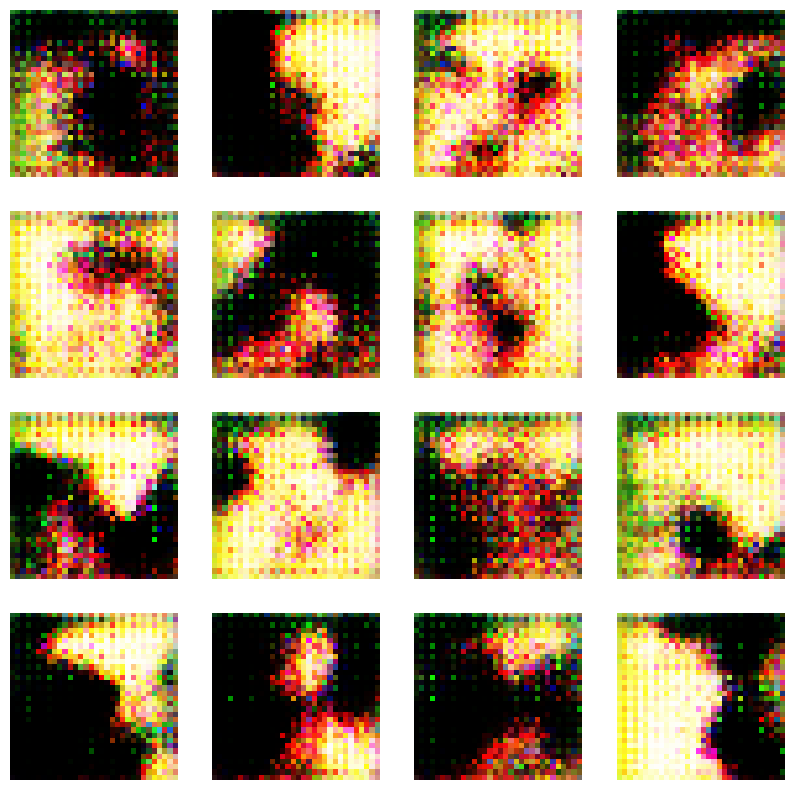

782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - d_loss: 2.1303 - g_loss: 4.1175
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - d_loss: 1.2710 - g_loss: 4.7455
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - d_loss: 2.5556 - g_loss: 6.1266
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - d_loss: 1.4872 - g_loss: 2.1938
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - d_loss: 1.2087 - g_loss: 1.7105
Epoch 6/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3351 - g_loss: 0.9368

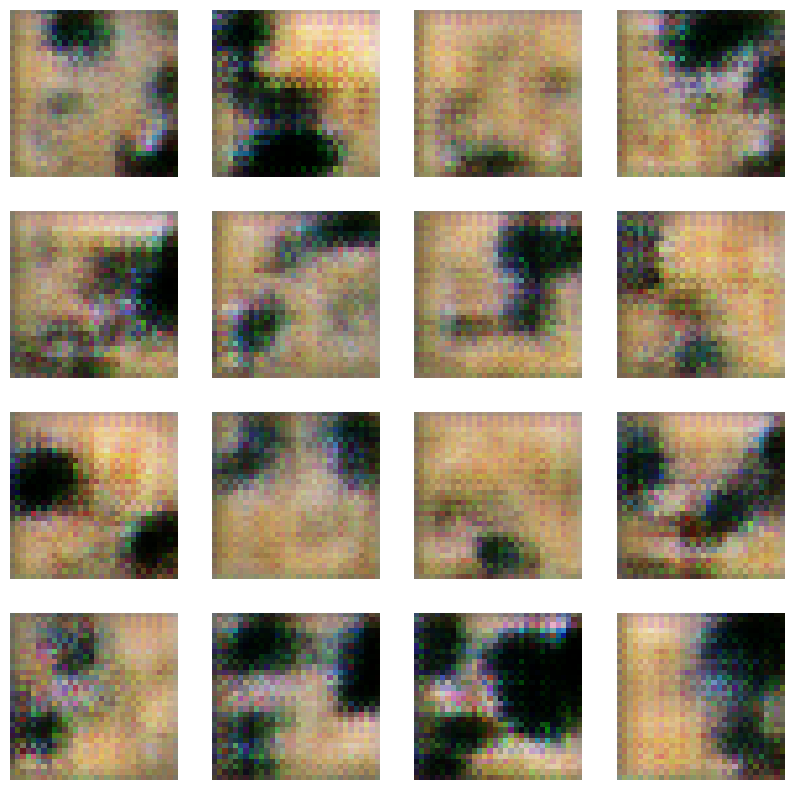

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3376 - g_loss: 0.9366
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - d_loss: 1.3869 - g_loss: 0.8616
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.4264 - g_loss: 0.7865
Epoch 9/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.4502 - g_loss: 0.7720
Epoch 10/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.4701 - g_loss: 0.7587
Epoch 11/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.4509 - g_loss: 0.7679

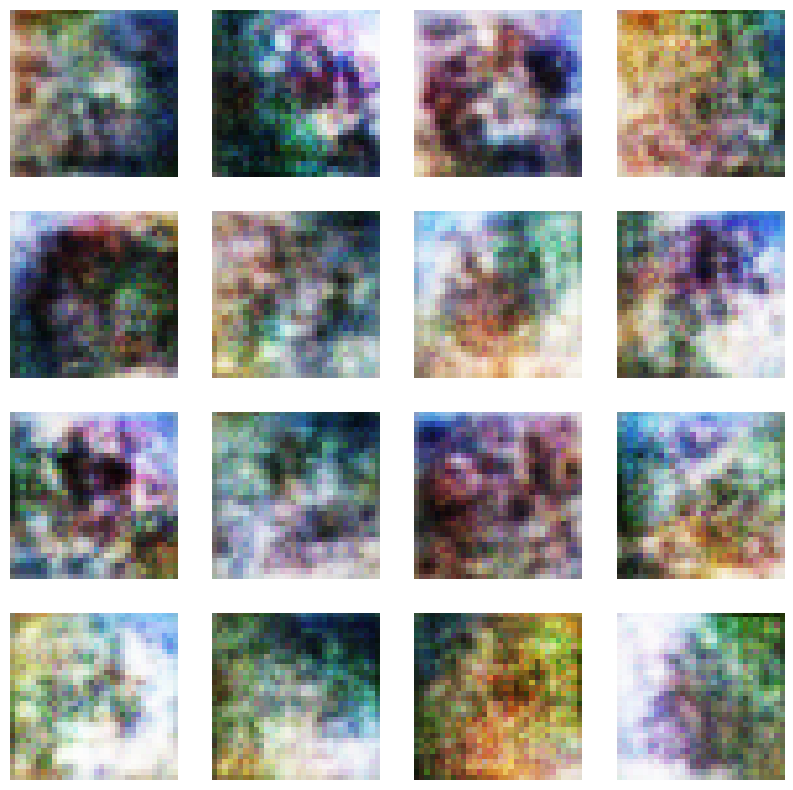

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - d_loss: 1.4509 - g_loss: 0.7679
Epoch 12/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - d_loss: 1.4264 - g_loss: 0.7976
Epoch 13/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3992 - g_loss: 0.8361
Epoch 14/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.3633 - g_loss: 1.0356
Epoch 15/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.3614 - g_loss: 0.8749
Epoch 16/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3369 - g_loss: 1.4736

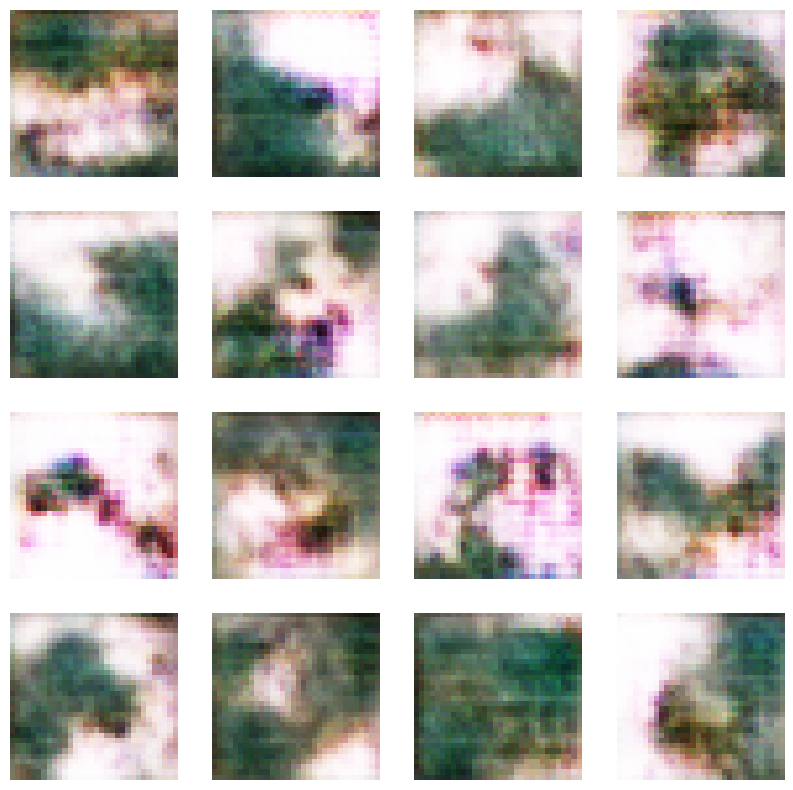

782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.3366 - g_loss: 1.4723
Epoch 17/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - d_loss: 0.8776 - g_loss: 8.8765
Epoch 18/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - d_loss: 2.4225 - g_loss: 3.1894
Epoch 19/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.2200 - g_loss: 1.2659
Epoch 20/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.2176 - g_loss: 0.9440
Epoch 21/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.2727 - g_loss: 0.9851

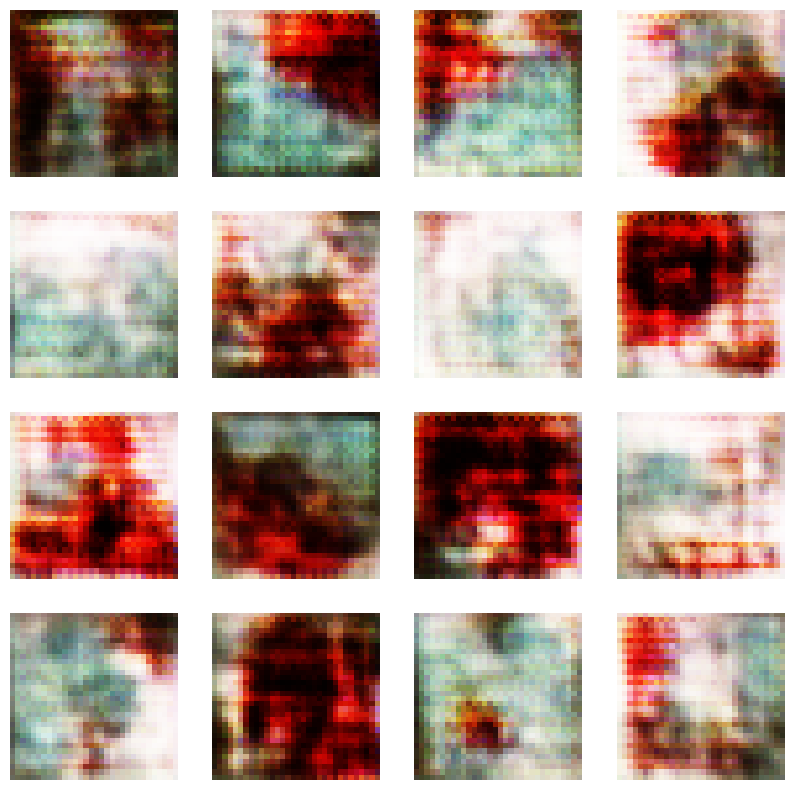

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.2725 - g_loss: 0.9852
Epoch 22/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.2861 - g_loss: 1.0392
Epoch 23/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.2799 - g_loss: 0.9354
Epoch 24/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.3201 - g_loss: 0.9391
Epoch 25/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.8528 - g_loss: 2.3723
Epoch 26/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3083 - g_loss: 1.2071

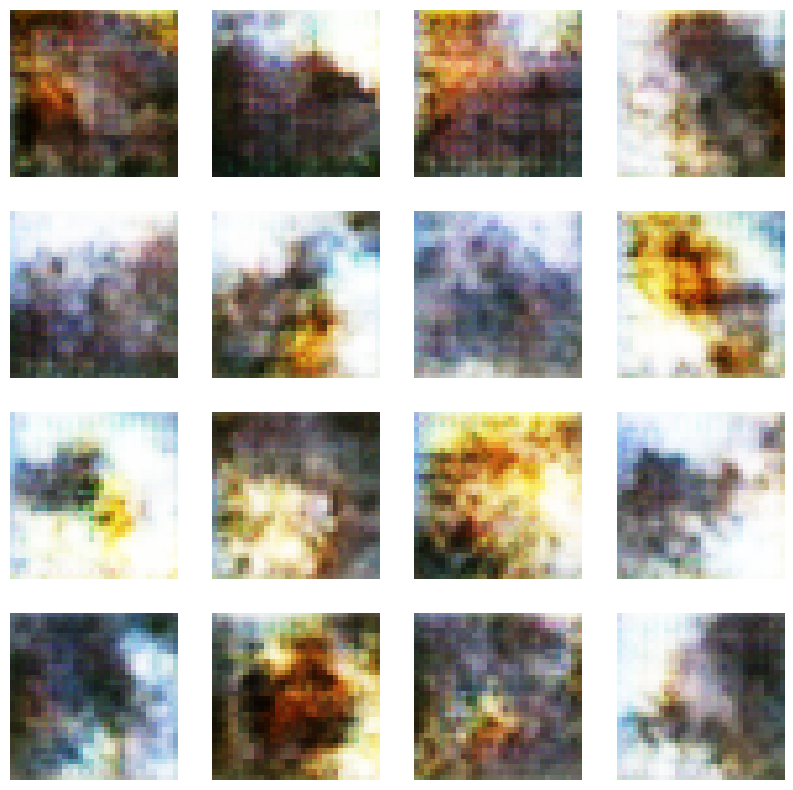

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3085 - g_loss: 1.2067
Epoch 27/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.2706 - g_loss: 1.0738
Epoch 28/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.2755 - g_loss: 0.9313
Epoch 29/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - d_loss: 1.9987 - g_loss: 3.7073
Epoch 30/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.5347 - g_loss: 0.9448
Epoch 31/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3577 - g_loss: 0.8524

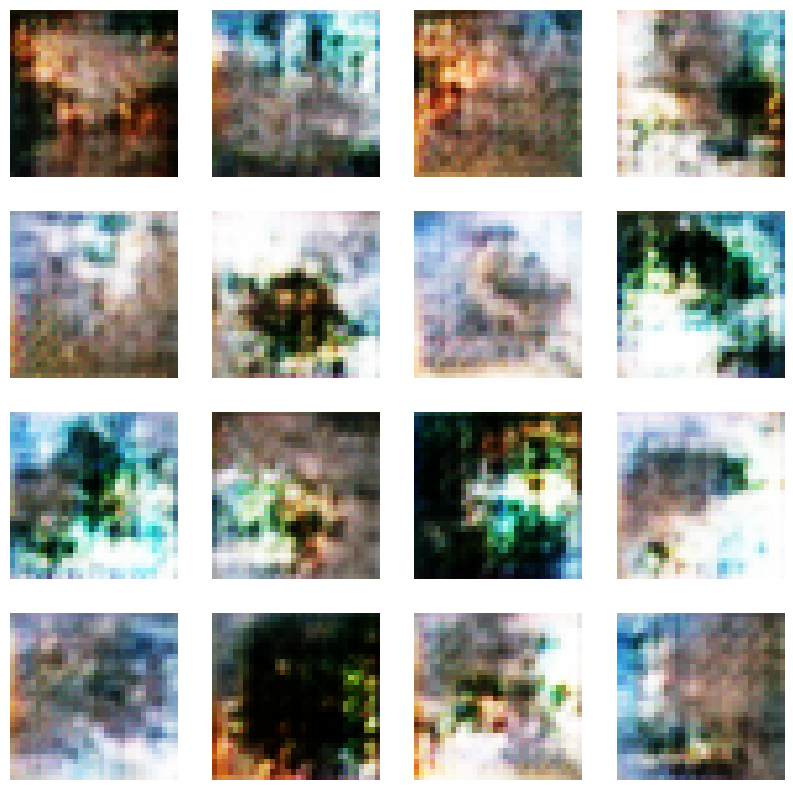

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3577 - g_loss: 0.8525
Epoch 32/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - d_loss: 1.3524 - g_loss: 0.8531
Epoch 33/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - d_loss: 1.3690 - g_loss: 0.8365
Epoch 34/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3921 - g_loss: 0.8289
Epoch 35/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 4.5227 - g_loss: 5.2061
Epoch 36/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3064 - g_loss: 1.5344

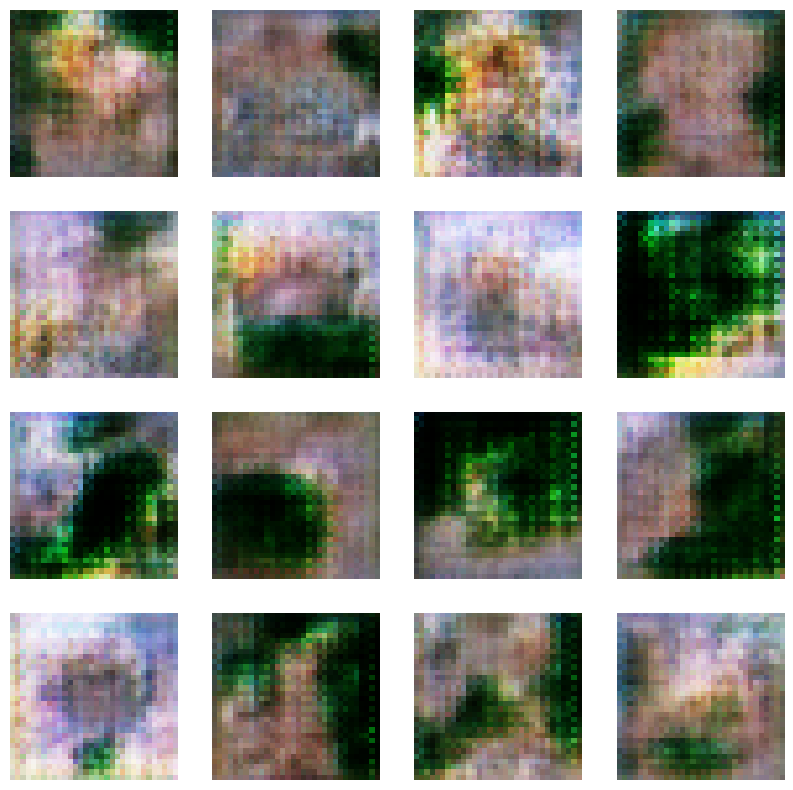

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3063 - g_loss: 1.5330
Epoch 37/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.3065 - g_loss: 0.8975
Epoch 38/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3446 - g_loss: 0.8520
Epoch 39/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3521 - g_loss: 0.8712
Epoch 40/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3606 - g_loss: 0.8555
Epoch 41/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.5366 - g_loss: 1.2897

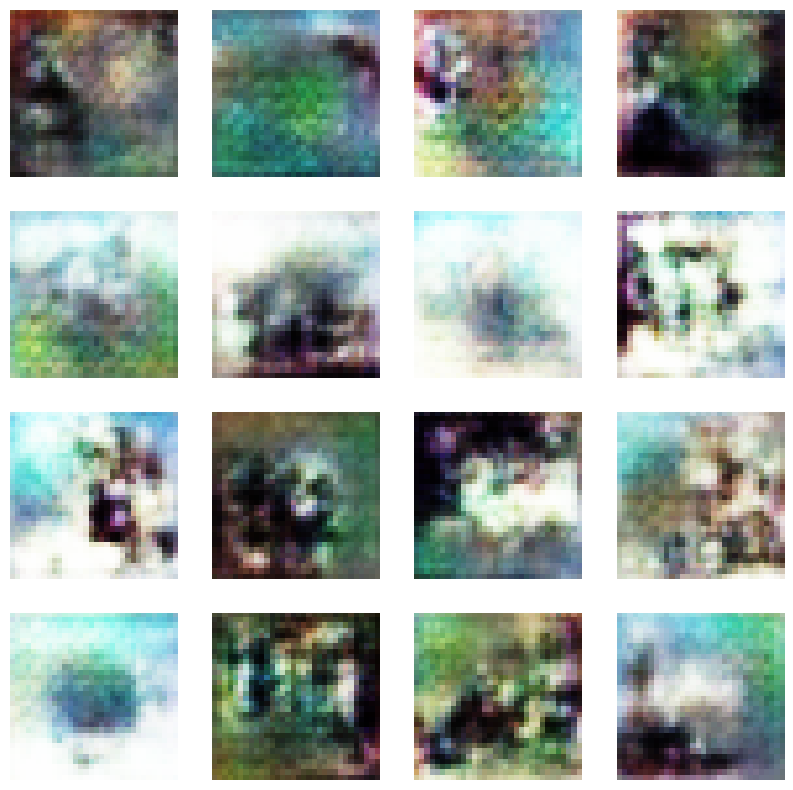

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - d_loss: 1.5360 - g_loss: 1.2886
Epoch 42/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3090 - g_loss: 1.1114
Epoch 43/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - d_loss: 2.3837 - g_loss: 2.3331
Epoch 44/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.3244 - g_loss: 0.9017
Epoch 45/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.2918 - g_loss: 0.9098
Epoch 46/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.4144 - g_loss: 0.9123

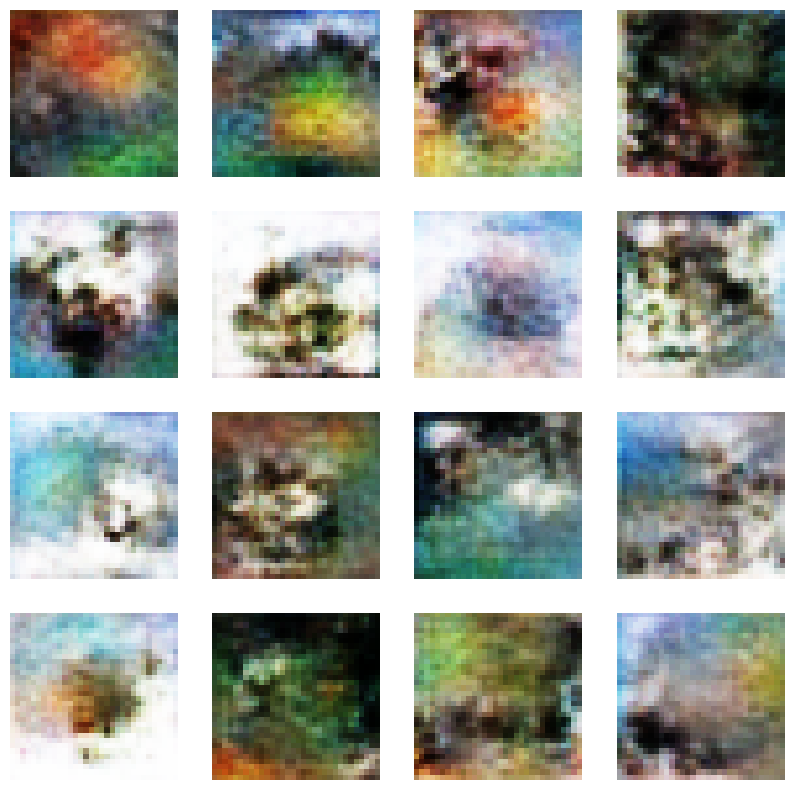

782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.4143 - g_loss: 0.9121
Epoch 47/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - d_loss: 1.3199 - g_loss: 0.9134
Epoch 48/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.9863 - g_loss: 1.0426
Epoch 49/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.3757 - g_loss: 0.8359
Epoch 50/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - d_loss: 1.3551 - g_loss: 0.8602
Epoch 51/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.4090 - g_loss: 0.9031

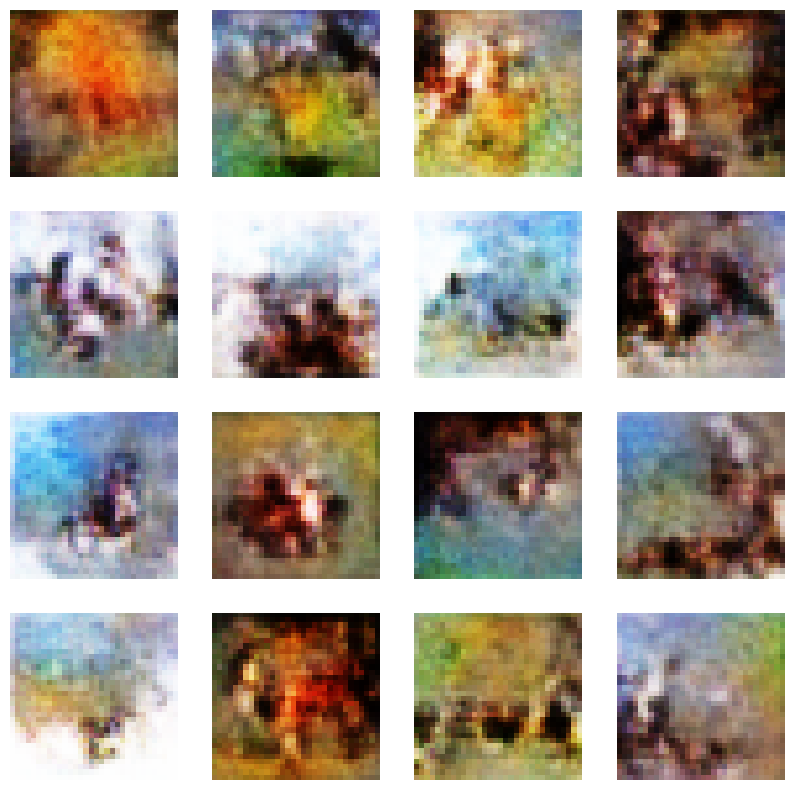

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - d_loss: 1.4088 - g_loss: 0.9028
Epoch 52/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3745 - g_loss: 0.8432
Epoch 53/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.3862 - g_loss: 0.8590
Epoch 54/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - d_loss: 1.3749 - g_loss: 0.8531
Epoch 55/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3722 - g_loss: 0.8660
Epoch 56/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3717 - g_loss: 0.8694

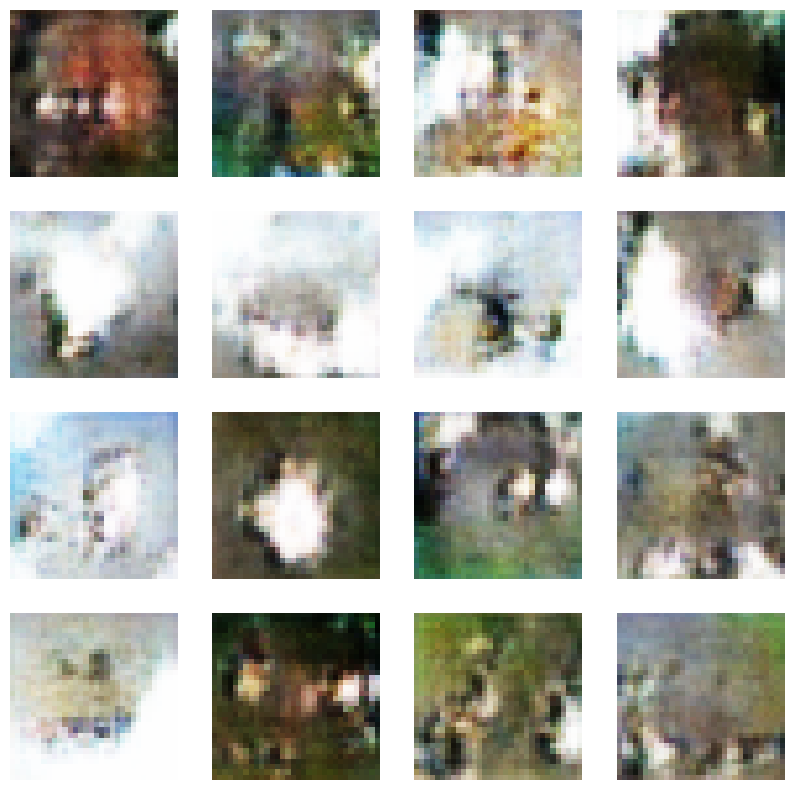

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - d_loss: 1.3716 - g_loss: 0.8695
Epoch 57/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - d_loss: 1.4046 - g_loss: 0.8698
Epoch 58/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.3557 - g_loss: 0.8515
Epoch 59/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.3546 - g_loss: 0.8631
Epoch 60/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - d_loss: 1.3630 - g_loss: 0.8647
Epoch 61/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.5442 - g_loss: 1.4920

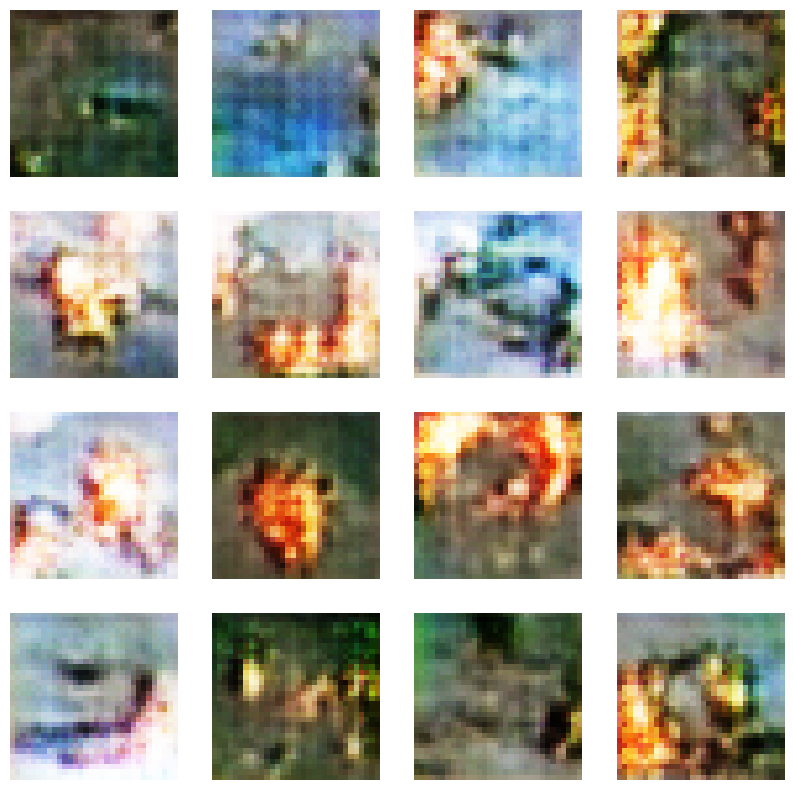

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.5436 - g_loss: 1.4907
Epoch 62/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.2840 - g_loss: 0.9281
Epoch 63/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - d_loss: 1.5061 - g_loss: 1.0182
Epoch 64/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3112 - g_loss: 0.8898
Epoch 65/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.3317 - g_loss: 0.8703
Epoch 66/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3421 - g_loss: 0.8623

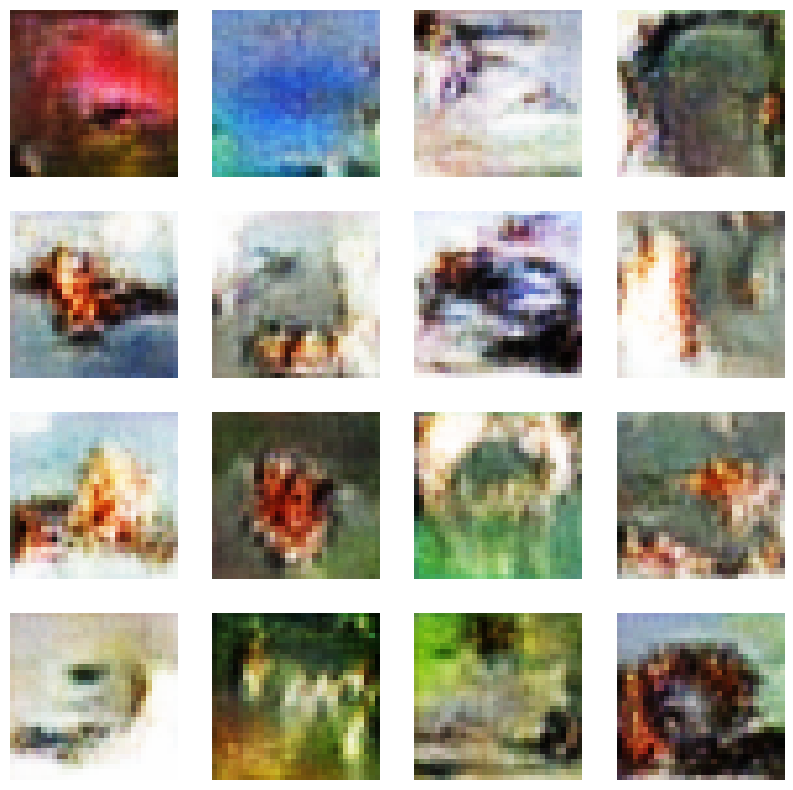

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3423 - g_loss: 0.8623
Epoch 67/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3614 - g_loss: 0.8488
Epoch 68/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.3665 - g_loss: 0.8484
Epoch 69/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - d_loss: 1.3737 - g_loss: 0.8472
Epoch 70/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3738 - g_loss: 0.8487
Epoch 71/100
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3738 - g_loss: 0.8459

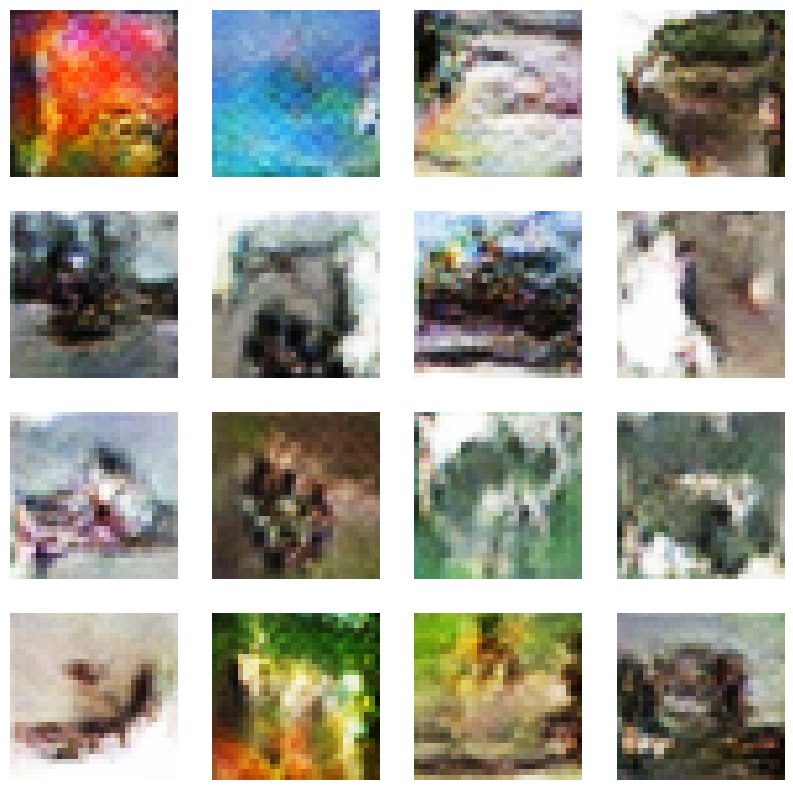

782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - d_loss: 1.3739 - g_loss: 0.8459
Epoch 72/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - d_loss: 1.3756 - g_loss: 0.8436
Epoch 73/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - d_loss: 1.3760 - g_loss: 0.8419
Epoch 74/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.3750 - g_loss: 0.8376
Epoch 75/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - d_loss: 1.3759 - g_loss: 0.8382
Epoch 76/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3758 - g_loss: 0.8345

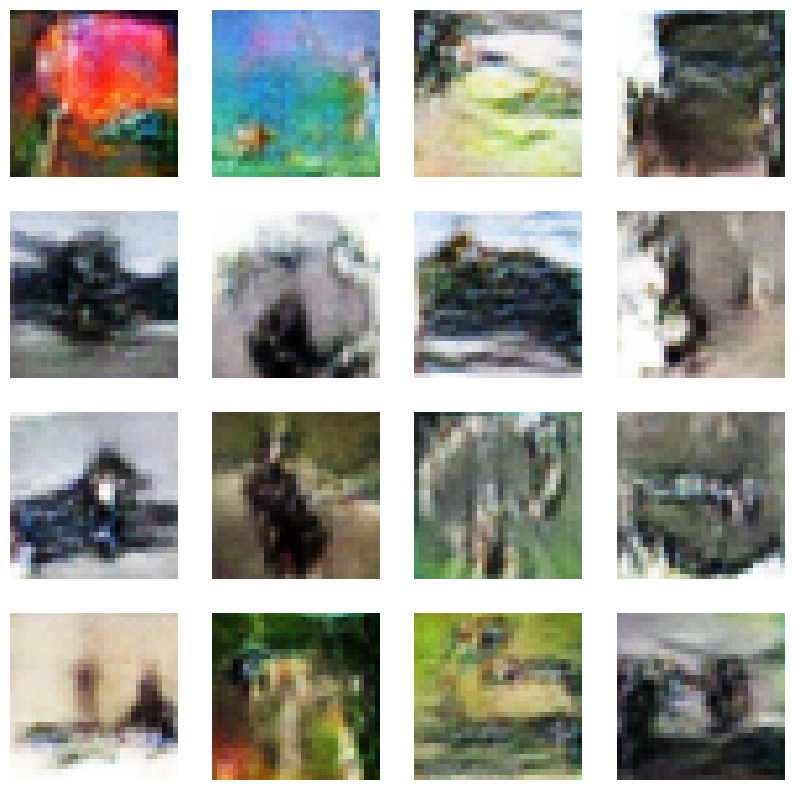

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3758 - g_loss: 0.8345
Epoch 77/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3756 - g_loss: 0.8340
Epoch 78/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3772 - g_loss: 0.8323
Epoch 79/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3759 - g_loss: 0.8293
Epoch 80/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.3779 - g_loss: 0.8278
Epoch 81/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3760 - g_loss: 0.8245

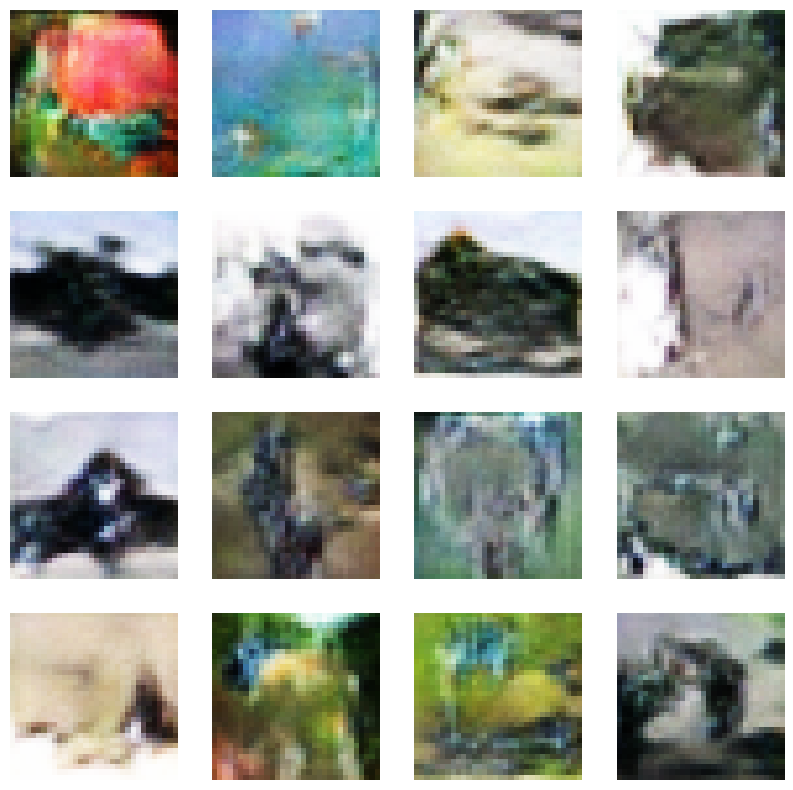

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - d_loss: 1.3759 - g_loss: 0.8247
Epoch 82/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - d_loss: 1.3774 - g_loss: 0.8230
Epoch 83/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - d_loss: 1.3776 - g_loss: 0.8230
Epoch 84/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3769 - g_loss: 0.8218
Epoch 85/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3763 - g_loss: 0.8197
Epoch 86/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3791 - g_loss: 0.8203

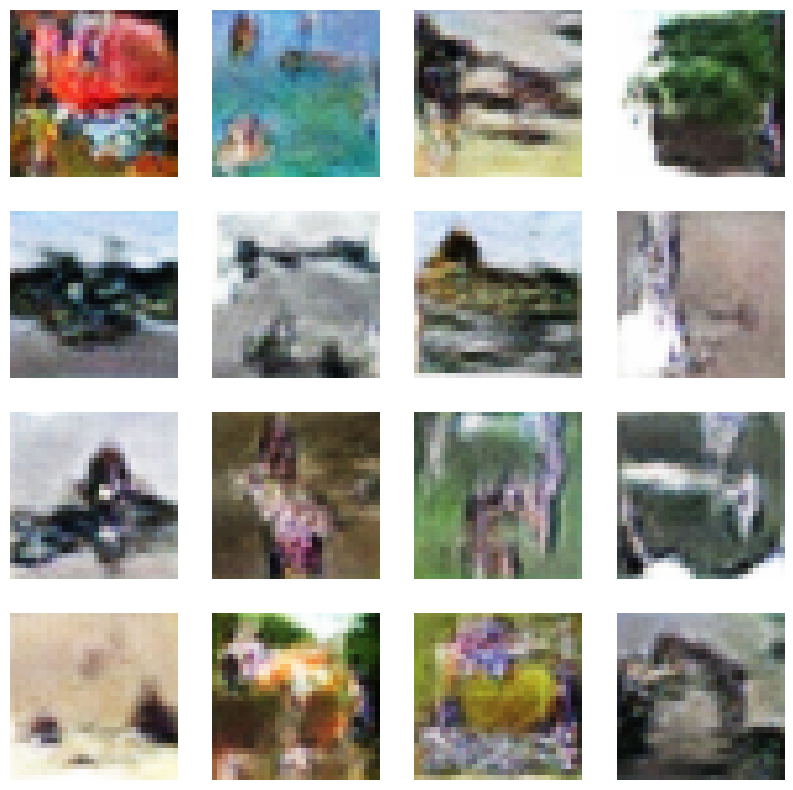

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - d_loss: 1.3791 - g_loss: 0.8203
Epoch 87/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - d_loss: 1.3776 - g_loss: 0.8186
Epoch 88/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.3766 - g_loss: 0.8164
Epoch 89/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.3782 - g_loss: 0.8181
Epoch 90/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3773 - g_loss: 0.8176
Epoch 91/100
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3763 - g_loss: 0.8171

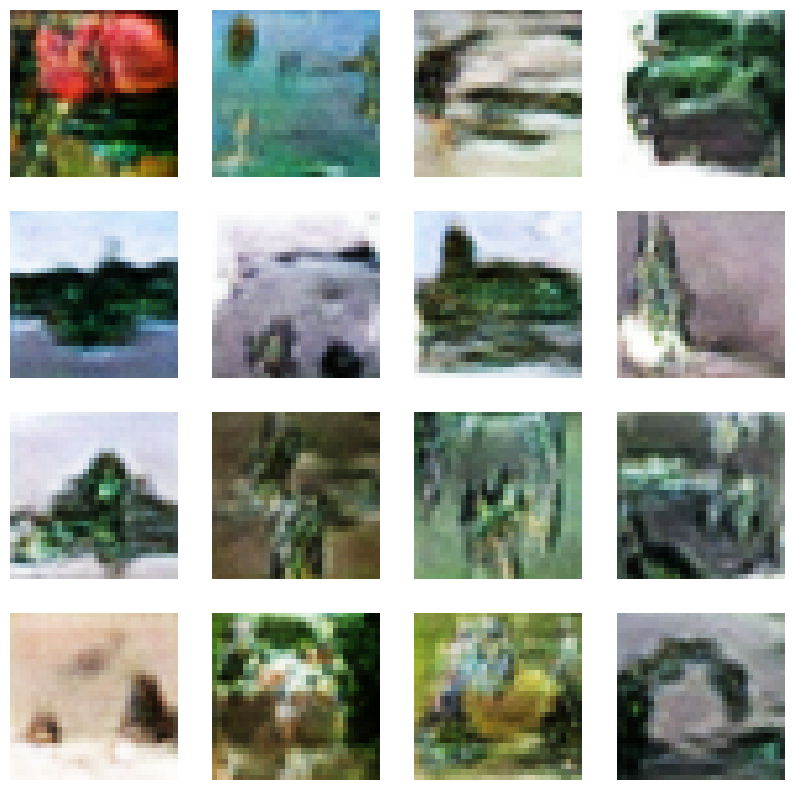

782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.3765 - g_loss: 0.8171
Epoch 92/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.3781 - g_loss: 0.8167
Epoch 93/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - d_loss: 1.3765 - g_loss: 0.8163
Epoch 94/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - d_loss: 1.3764 - g_loss: 0.8162
Epoch 95/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3770 - g_loss: 0.8181
Epoch 96/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3752 - g_loss: 0.8170

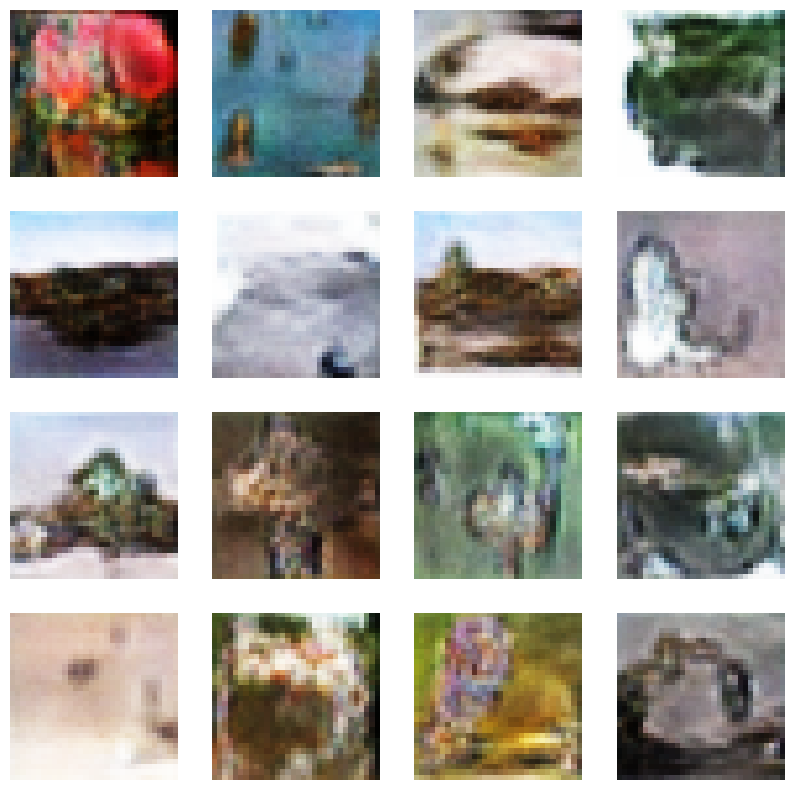

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - d_loss: 1.3752 - g_loss: 0.8171
Epoch 97/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3759 - g_loss: 0.8183
Epoch 98/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3760 - g_loss: 0.8169
Epoch 99/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - d_loss: 1.3766 - g_loss: 0.8211
Epoch 100/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - d_loss: 1.3748 - g_loss: 0.8175


In [32]:
history = gan.fit(train_dataset, epochs=EPOCH, callbacks=[ImageCallback()])

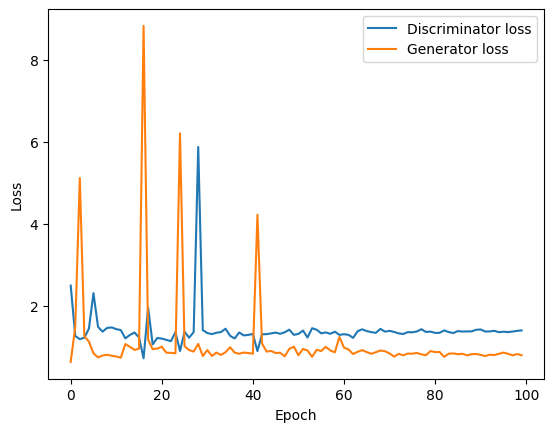

In [33]:
plt.plot(history.history['d_loss'], label='Discriminator loss')
plt.plot(history.history['g_loss'], label='Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
# Test the generator
noise = tf.random.normal([25, LATENT_DIM])
generated_images = genrator(noise)
generated_images = (generated_images * 127.5) + 127.5

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

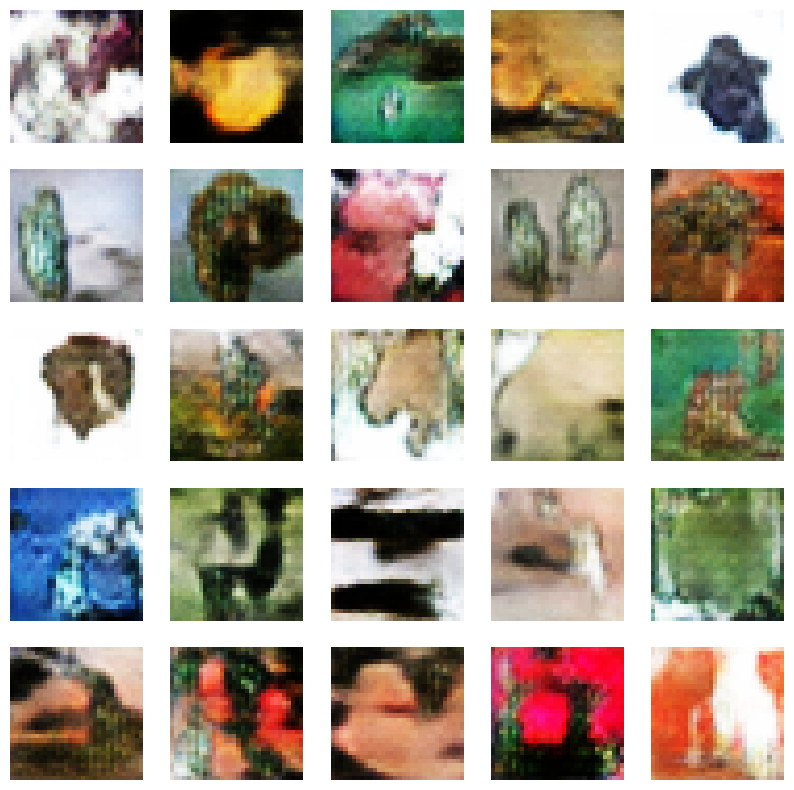

In [35]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
  plt.axis("off")
plt

In [37]:
genrator.save("cifar_images.h5")

In [40]:
from google.colab import drive
drive.mount('/content/drive') # Change the mountpoint to /content/drive

Mounted at /content/drive


In [41]:
genrator.save('/content/drive/MyDrive/cifar_images.h5')